In [6]:
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import re
import glob
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter

In [7]:
DEBUG = True  # Mets False pour désactiver les prints
def debug_print(*args):
    if DEBUG:
        print(*args)

import os
import subprocess

def say(text):
    """
    Dit le texte à un volume élevé puis remet le volume normal.
    macOS only.
    """
    current_volume = int(subprocess.check_output(
        "osascript -e 'output volume of (get volume settings)'", shell=True
    ).strip())
    
    os.system("osascript -e 'set volume output volume 40'")
    
    os.system(f'say "{text}"')
    
    os.system(f"osascript -e 'set volume output volume {current_volume}'")
    

In [8]:
say("mille bière s'il vous plait" )

In [9]:
SEGMENTS_DIR = "preprocessed_data/segments"
DATA_DIR = os.path.join(os.getcwd(), "TERBINAFINE")
LIFESPAN_FILE = os.path.join(DATA_DIR, "lifespan_summary.csv")
SEGMENT_LENGTH = 900 
FEATURE_COLS = ['X', 'Y', 'Speed', 'turning_angle'] 
KEEP_SEGMENTS_WITH_DEATH_INSIDE = True
try:
    lifespan_df = pd.read_csv(LIFESPAN_FILE)
except Exception as e:
    print(f"ERREUR FATALE: impossible de lire {LIFESPAN_FILE}: {e}")
    raise SystemExit(1)

lifespan_df.columns = lifespan_df.columns.str.strip()
colmap = {c.lower(): c for c in lifespan_df.columns}

filename_col = colmap.get('filename') or colmap.get('file_name') or colmap.get('files') or colmap.get('source_file') or colmap.get('file')
life_col = colmap.get('lifespaninframes') or colmap.get('lifespan') or colmap.get('lifespan_in_frames') or colmap.get('lifespanframes') or colmap.get('total_frames')

if filename_col is None or life_col is None:
    print("Colonnes attendues introuvables dans lifespan_summary.csv. Colonnes disponibles:")
    print(list(lifespan_df.columns))
    raise SystemExit(1)

# Construire Worm_ID normalisé (sans extension, sans leading slash)
lifespan_df['Worm_ID_raw'] = lifespan_df[filename_col].astype(str)
lifespan_df['Worm_ID'] = lifespan_df['Worm_ID_raw'].apply(lambda x: os.path.splitext(x.strip())[0].lstrip('/'))
lifespan_map = lifespan_df.set_index('Worm_ID')[life_col].to_dict()

print(f"Loaded {len(lifespan_df)} lifespan entries. Example keys: {list(lifespan_map.keys())[:5]}")
print("-" * 60)

Loaded 104 lifespan entries. Example keys: ['20240924_piworm09_1', '20240924_piworm09_2', '20240924_piworm09_3', '20240924_piworm09_4', '20240924_piworm09_5']
------------------------------------------------------------


In [10]:
segment_files = glob.glob(os.path.join(SEGMENTS_DIR, "*.csv"))
all_segments = []
rejection_counts = Counter({
    'No_Lifespan_Match': 0,
    'Missing_Features': 0,
    'Pattern_Mismatch': 0,
    'After_Death': 0,
    'Other': 0
})

for file in segment_files:
    debug_print("\n--------------------------------------")
    debug_print(f"🔍 Checking file: {file}")

    try:
        df = pd.read_csv(file)
        debug_print("   ✔ CSV loaded successfully")
    except Exception as e:
        rejection_counts['Other'] += 1
        debug_print("   ❌ Could not read CSV:", e)
        continue

    # --------------------------
    # directly use worm_id
    # --------------------------
    if "worm_id" not in df.columns:
        rejection_counts['Other'] += 1
        debug_print("   ❌ Missing worm_id column")
        continue

    worm_id_candidate = str(df["worm_id"].iloc[0]).strip()
    debug_print("   ✔ worm_id extracted:", worm_id_candidate)

    # --------------------------
    # Lifespan lookup
    # --------------------------
    total_lifespan = lifespan_map.get(worm_id_candidate)

    if total_lifespan is None:
        rejection_counts['No_Lifespan_Match'] += 1
        debug_print(f"   ❌ No lifespan match for '{worm_id_candidate}' → reject")
        continue

    debug_print("   ✔ Lifespan found:", total_lifespan)

    # --------------------------
    # Feature verification
    # --------------------------
    missing_features = [col for col in FEATURE_COLS if col not in df.columns]
    if missing_features:
        rejection_counts['Missing_Features'] += 1
        debug_print("   ❌ Missing features:", missing_features)
        continue

    # --------------------------
    # Frames / Length
    # --------------------------
    try:
        segment_start_frame = int(df['GlobalFrame'].iloc[0])
    except Exception:
        rejection_counts['Other'] += 1
        continue

    original_length = df.shape[0]
    if original_length == 0:
        rejection_counts['Other'] += 1
        continue

    # --------------------------
    # Feature array + padding
    # --------------------------
    features = df[FEATURE_COLS].values.astype(np.float32)
    current_length = features.shape[0]

    if current_length > SEGMENT_LENGTH:
        features = features[:SEGMENT_LENGTH, :]
        used_length = SEGMENT_LENGTH
    else:
        padding_needed = SEGMENT_LENGTH - current_length
        features = np.pad(features, ((0, padding_needed), (0, 0)),
                          mode='constant', constant_values=0.0)
        used_length = current_length

    # Mask
    mask = np.zeros((SEGMENT_LENGTH,), dtype=np.float32)
    mask[:used_length] = 1.0

    # --------------------------
    # Target: time-to-death
    # --------------------------
    """
    last_frame_observed = segment_start_frame + used_length - 1
    time_to_death_from_end = int(total_lifespan - last_frame_observed)
    debug_print(" time_to_death_from_end:", time_to_death_from_end)

    if time_to_death_from_end < 0:
        if KEEP_SEGMENTS_WITH_DEATH_INSIDE:
            target = 0.0
        else:
            rejection_counts['After_Death'] += 1
            continue
    else:
        target = float(time_to_death_from_end)
    """
    last_frame_observed = segment_start_frame + used_length - 1
    pct_life_remaining = max(0.0, (total_lifespan - last_frame_observed) / total_lifespan)
    target = float(pct_life_remaining)
    # --------------------------
    # Store segment
    # --------------------------
    all_segments.append({
        'features': features,
        'mask': mask,
        'y': target,
        'worm_id': worm_id_candidate,
        'start_frame': segment_start_frame,
        'valid_length': used_length
    })

print("---- Résumé chargement des segments ----")
print(f"Segments fichiers trouvés: {len(segment_files)}")
print(f"Segments acceptés : {len(all_segments)}")
print("Rejection counts:", dict(rejection_counts))
if len(all_segments) == 0:
    print("ERREUR: Aucun segment utilisable après filtrage.")
    raise SystemExit(1)
print("-" * 60)


--------------------------------------
🔍 Checking file: preprocessed_data/segments/coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv
   ✔ CSV loaded successfully
   ✔ worm_id extracted: 20250205_piworm09_3
   ✔ Lifespan found: 58500

--------------------------------------
🔍 Checking file: preprocessed_data/segments/coordinates_highestspeed_20240924_11_1_with_time_speed-fragment33.0-preprocessed.csv
   ✔ CSV loaded successfully
   ✔ worm_id extracted: 20240924_piworm11_1
   ✔ Lifespan found: 61200

--------------------------------------
🔍 Checking file: preprocessed_data/segments/coordinates_highestspeed_20240924_12_6_with_time_speed-fragment19.0-preprocessed.csv
   ✔ CSV loaded successfully
   ✔ worm_id extracted: 20240924_piworm12_6
   ✔ Lifespan found: 72000

--------------------------------------
🔍 Checking file: preprocessed_data/segments/coordinates_highestspeed_20250415_9_1_with_time_speed-fragment56.0-preprocessed.csv
   ✔ CSV loaded successfull

In [11]:
import numpy as np

def debug_segment_nans(segment, segment_idx=None, show_values=True):
    """
    Inspect a segment's features for NaNs.
    
    Args:
        segment: dict with keys 'features', 'worm_id', ...
        segment_idx: optional index for reference in prints
        show_values: if True, prints the actual row values containing NaNs
    """
    features = segment['features']
    worm_id = segment.get('worm_id', 'unknown')
    n_rows, n_cols = features.shape
    
    if segment_idx is not None:
        print(f"\n--- Debug Segment {segment_idx} ---")
    else:
        print("\n--- Debug Segment ---")
    print(f"Worm ID: {worm_id}")
    print(f"Shape: {features.shape}")
    
    # Total NaNs
    total_nans = np.isnan(features).sum()
    print(f"Total NaNs in segment: {total_nans}")
    
    if total_nans == 0:
        print("No NaNs found in this segment.")
        return
    
    # NaNs per column
    nan_per_column = np.sum(np.isnan(features), axis=0)
    print("\nNaNs per column:")
    for idx, count in enumerate(nan_per_column):
        if count > 0:
            print(f"  Column {idx}: {count} NaNs")
    
    # NaNs per row
    nan_per_row = np.sum(np.isnan(features), axis=1)
    rows_with_nan = np.where(nan_per_row > 0)[0]
    print("\nRows containing NaNs:", rows_with_nan)
    print("NaNs per row:", nan_per_row[rows_with_nan])
    
    # Optional: print row values containing NaNs
    if show_values:
        print("\nRows with NaNs (full row values):")
        for r in rows_with_nan:
            print(f"  Row {r}: {features[r]}")
    
    # Optional: show which columns are NaN per row
    print("\nNaN positions (row x column):")
    for r in rows_with_nan:
        nan_cols = np.where(np.isnan(features[r]))[0]
        print(f"  Row {r}: NaN in columns {nan_cols}")


In [12]:
from collections import defaultdict
def fix_segment_nans(segment):
    feats = segment['features']  # (T, F)

    import pandas as pd
    df = pd.DataFrame(feats)

    # 1) fill using the value under (bfill)
    df = df.bfill()

    # 2) if still NaN, fill using the value above (ffill)
    df = df.ffill()

    segment['features'] = df.values.astype(np.float32)
    return segment

all_segments_clean = []
for seg in all_segments:
    all_segments_clean.append(fix_segment_nans(seg))
    
all_segments_clean = [
    seg for seg in all_segments
    if not np.isnan(seg['features']).any()
]
print("Segments without NaNs after cleaning:", len(all_segments_clean))


# Group segments by worm_id
worm_to_segments = defaultdict(list)
for seg in all_segments:
    worm_to_segments[seg['worm_id']].append(seg)

# List of worm IDs
all_worm_ids = list(worm_to_segments.keys())

# Split worms: 70% train, 15% val, 15% test
train_worms, temp_worms = train_test_split(all_worm_ids, test_size=0.3, random_state=42)
val_worms, test_worms = train_test_split(temp_worms, test_size=0.5, random_state=42)

# Create actual datasets
def get_segments_from_worms(worm_list):
    segments = []
    for w in worm_list:
        segments.extend(worm_to_segments[w])
    return segments

train_segments = get_segments_from_worms(train_worms)
val_segments = get_segments_from_worms(val_worms)
test_segments = get_segments_from_worms(test_worms)

print(f"Train segments: {len(train_segments)}")
print(f"Val segments: {len(val_segments)}")
print(f"Test segments: {len(test_segments)}")

Segments without NaNs after cleaning: 8156
Train segments: 5674
Val segments: 1363
Test segments: 1119


In [13]:
def prepare_X_y(segments, coord_indices=[2,3]):  # speed, truning angle columns
    X = np.array([seg['features'][:, coord_indices] for seg in segments])
    y = np.array([seg['y'] for seg in segments])
    mask = np.array([seg['mask'] for seg in segments])
    return X, y, mask

X_train, y_train, mask_train = prepare_X_y(train_segments)
X_val, y_val, mask_val = prepare_X_y(val_segments)
X_test, y_test, mask_test = prepare_X_y(test_segments)

print("Shapes:", X_train.shape, y_train.shape)


Shapes: (5674, 900, 2) (5674,)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

# Mask padded frames
mask_value = 0.0
    
model = Sequential([
    # 1. Masking
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. 💥 Ajout d'une première couche LSTM plus large
    # return_sequences=True est crucial pour passer la sortie complète à la couche suivante
    LSTM(256, return_sequences=True, 
            kernel_regularizer=regularizers.l2(0.0001)),
    
    # 3. 📉 Dropout pour éviter l'overfitting entre les couches
    Dropout(0.2),
    
    # 4. 💥 Ajout d'une seconde couche LSTM
    # return_sequences=False car c'est la dernière couche récurrente
    LSTM(128, return_sequences=False, 
            kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.1),

    
    # 6. Couches Denses plus profondes
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    
    # 7. Sortie de régression (activation linéaire par défaut)
    Dense(1) 
])
    

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.Huber(delta=2.0), 
        metrics=['mae']
    )
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train,           # predict normalized target
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)
say("Votre code est terminé")

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - loss: 0.0592 - mae: 0.2019 - val_loss: 0.0411 - val_mae: 0.1777
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - loss: 0.0401 - mae: 0.1846 - val_loss: 0.0361 - val_mae: 0.1823
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - loss: 0.0366 - mae: 0.1881 - val_loss: 0.0512 - val_mae: 0.2392
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - loss: 0.0338 - mae: 0.1861 - val_loss: 0.0301 - val_mae: 0.1758
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - loss: 0.0314 - mae: 0.1840 - val_loss: 0.0413 - val_mae: 0.2341
Epoch 6/50
 19/178 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - loss: 0.0495 - mae: 0.2566

KeyboardInterrupt: 

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step
--- RESULTATS (Global Norm - Speed/Angle Only) ---
R2 Score : 0.2675
MAE      : 0.1874


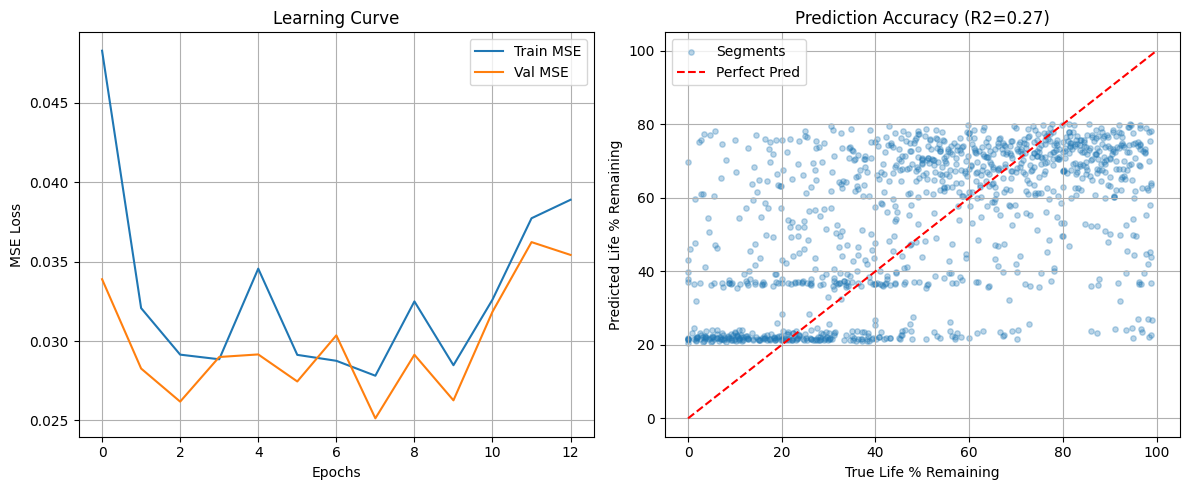

In [15]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- RESULTATS (Global Norm - Speed/Angle Only) ---")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Scatter Plot Prédictions
plt.subplot(1, 2, 2)
plt.scatter(y_test*100, y_pred*100, alpha=0.3, s=15, label='Segments')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Pred')
plt.title(f'Prediction Accuracy (R2={r2:.2f})')
plt.xlabel('True Life % Remaining')
plt.ylabel('Predicted Life % Remaining')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

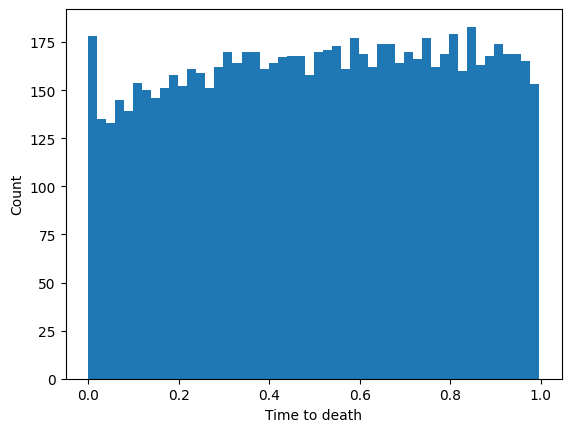

Mean: 0.5092985561979321 Std: 0.2839646906629497
Feature min/max/mean/std:
[ 0.          0.         -0.84012383 -1.        ]
[1.       1.       8.063646 1.      ]
[ 0.5580893   0.47806713  0.00095116 -0.00251161]
[0.18850817 0.20905334 0.9817247  0.51957905]
[0.29118448 0.2795263  0.7005999  ... 0.6232506  0.5338918  0.66699886]


In [12]:
#check j'essaie de comprendre ce qui va pas 

all_targets = np.array([seg['y'] for seg in all_segments])
plt.hist(all_targets, bins=50)
plt.xlabel("Time to death")
plt.ylabel("Count")
plt.show()
print("Mean:", np.mean(all_targets), "Std:", np.std(all_targets))


feature_matrix = np.vstack([seg['features'] for seg in all_segments])
print("Feature min/max/mean/std:")
print(np.min(feature_matrix, axis=0))
print(np.max(feature_matrix, axis=0))
print(np.mean(feature_matrix, axis=0))
print(np.std(feature_matrix, axis=0))

print(y_pred)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step
MAE: 16444.335
RMSE: 19801.778
R²: 0.053


Segments -> Train: 5674, Val: 1363, Test: 1119
Calcul des statistiques globales sur le Train set...
Stats Globales : {'speed_mean': np.float32(1.4552386), 'speed_std': np.float32(2.2497718), 'angle_mean': np.float32(-0.0024692104), 'angle_std': np.float32(0.53270763)}
Construction des tenseurs...
Shape Input Final: (5674, 900, 2)


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_21 (Masking)            │ (None, 100, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100, 64)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,657 (119.75 KB)

 Trainable params: 30,657 (119.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
89/89 - 46s - 515ms/step - loss: 44.3102 - mae: 44.8074 - mse: 2786.9763 - val_loss: 38.8149 - val_mae: 39.3119 - val_mse: 2192.2488
Epoch 2/20
89/89 - 42s - 469ms/step - loss: 31.2038 - mae: 31.7002 - mse: 1484.2904 - val_loss: 26.3631 - val_mae: 26.8597 - val_mse: 1024.4755
Epoch 3/20
89/89 - 44s - 493ms/step - loss: 24.9773 - mae: 25.4732 - mse: 881.6574 - val_loss: 23.7876 - val_mae: 24.2850 - val_mse: 797.7083
Epoch 4/20
89/89 - 43s - 485ms/step - loss: 24.3700 - mae: 24.8667 - mse: 835.6124 - val_loss: 23.6538 - val_mae: 24.1497 - val_mse: 788.6795
Epoch 5/20
89/89 - 41s - 459ms/step - loss: 24.3216 - mae: 24.8191 - mse: 834.8727 - val_loss: 23.6471 - val_mae: 24.1432 - val_mse: 788.3484
Epoch 6/20
89/89 - 42s - 467ms/step - loss: 24.3767 - mae: 24.8734 - mse: 836.1122 - val_loss: 23.6168 - val_mae: 24.1130 - val_mse: 784.8615
Epoch 7/20
89/89 - 400s - 4s/step - loss: 24.3311 - mae: 24.8280 - mse: 831.2485 - val_loss: 23.6215 - val_mae: 24.1176 - val_mse: 784.9474
Epoc

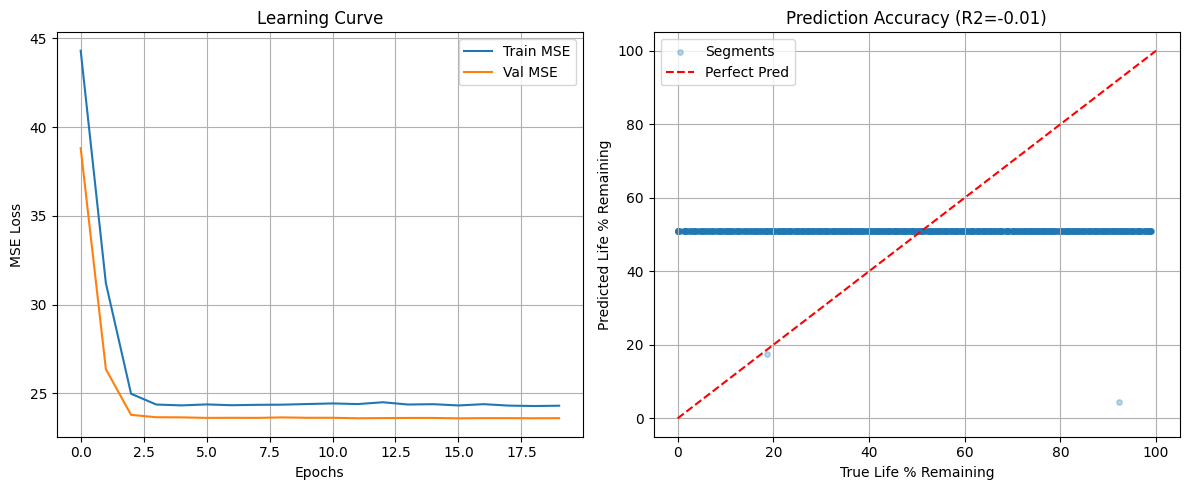

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================
# 0. CONFIGURATION & DONNEES
# ==========================================
SEGMENT_LENGTH = 100 

# On suppose que 'all_segments' est déjà chargé
# On suppose que 'lifespan_map' est disponible
try: lifespan_map 
except NameError: lifespan_map = None

# --- Split Worm-Level (Comme avant) ---
# On s'assure de ne pas mélanger les vers entre train et test
worm_to_segments = defaultdict(list)
for seg in all_segments:
    # Petit check de sécurité anti-NaN
    if not np.isnan(seg['features']).any():
        worm_to_segments[seg['worm_id']].append(seg)

all_worm_ids = list(worm_to_segments.keys())
train_worms, temp_worms = train_test_split(all_worm_ids, test_size=0.3, random_state=42)
val_worms, test_worms = train_test_split(temp_worms, test_size=0.5, random_state=42)

def get_segments(w_list):
    res = []
    for w in w_list: res.extend(worm_to_segments[w])
    return res

train_segments = get_segments(train_worms)
val_segments   = get_segments(val_worms)
test_segments  = get_segments(test_worms)

print(f"Segments -> Train: {len(train_segments)}, Val: {len(val_segments)}, Test: {len(test_segments)}")

# ==========================================
# 1. CALCUL DES STATISTIQUES GLOBALES (CRUCIAL)
# ==========================================
def compute_global_stats(segment_list):
    """
    Parcourt tout le training set pour trouver la moyenne et l'écart-type
    GLOBAL de la Vitesse et de l'Angle.
    """
    all_speeds = []
    all_angles = []

    print("Calcul des statistiques globales sur le Train set...")
    for seg in segment_list:
        # On suppose: col 2 = Speed, col 3 = Angle
        feats = seg['features']
        mask = seg['mask'].astype(bool)
        
        # On ne prend que les frames valides (pas le padding)
        valid_feats = feats[mask]
        
        if len(valid_feats) > 0:
            all_speeds.append(valid_feats[:, 2]) # Speed
            all_angles.append(valid_feats[:, 3]) # Angle

    # Concaténation géante
    flat_speeds = np.concatenate(all_speeds)
    flat_angles = np.concatenate(all_angles)

    stats = {
        'speed_mean': np.mean(flat_speeds),
        'speed_std':  np.std(flat_speeds),
        'angle_mean': np.mean(flat_angles),
        'angle_std':  np.std(flat_angles)
    }
    
    # Sécurité division par zero
    if stats['speed_std'] < 1e-6: stats['speed_std'] = 1.0
    if stats['angle_std'] < 1e-6: stats['angle_std'] = 1.0
    
    return stats

# On calcule les stats UNIQUEMENT sur le Train (pour ne pas tricher)
GLOBAL_STATS = compute_global_stats(train_segments)
print(f"Stats Globales : {GLOBAL_STATS}")

# ==========================================
# 2. PREPARATION DES FEATURES (NORMALISATION GLOBALE)
# ==========================================
def get_normalized_features(seg, stats):
    """
    Ne garde que Speed et Angle.
    Normalise avec les stats globales passées en argument.
    """
    # Extraction : Col 2 (Speed) et 3 (Angle) uniquement
    # Shape initiale (T, 4) -> On veut (T, 2)
    raw_feats = seg['features'][:, 2:4].astype(np.float32) 
    mask = seg['mask'].astype(bool)
    
    # Création du tableau de sortie
    norm_feats = np.zeros_like(raw_feats)
    
    # Application de la formule (X - Mean) / Std
    # Speed (colonne 0 de raw_feats désormais)
    norm_feats[:, 0] = (raw_feats[:, 0] - stats['speed_mean']) / stats['speed_std']
    
    # Angle (colonne 1 de raw_feats désormais)
    norm_feats[:, 1] = (raw_feats[:, 1] - stats['angle_mean']) / stats['angle_std']
    
    # Masquage strict (Remettre le padding à 0)
    norm_feats[~mask] = 0.0
    
    return norm_feats

def build_dataset(seg_list, stats, lifespan_map=None):
    X_list, y_list = [], []

    for seg in seg_list:
        # 1. Features Processing
        inp = get_normalized_features(seg, stats)
        X_list.append(inp)

        # 2. Target Processing (Life %)
        y_frames = seg['y']
        life_pct = np.nan
        
        if lifespan_map:
            w_id = seg['worm_id']
            life = lifespan_map.get(w_id)
            if life is None and isinstance(w_id, str):
                 life = lifespan_map.get('/' + w_id)
            
            if life is not None and life > 0:
                life_pct = 100.0 * (y_frames / life)
        
        y_list.append(life_pct)

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.array(y_list, dtype=np.float32)
    
    return X, y

# Construction des datasets en utilisant TOUJOURS les stats du TRAIN
print("Construction des tenseurs...")
X_train, y_train_raw = build_dataset(train_segments, GLOBAL_STATS, lifespan_map)
X_val,   y_val_raw   = build_dataset(val_segments,   GLOBAL_STATS, lifespan_map)
X_test,  y_test_raw  = build_dataset(test_segments,  GLOBAL_STATS, lifespan_map)

# Filtrage des NaNs (si lifespan manquant)
def filter_nans(X, y):
    mask = ~np.isnan(y)
    return X[mask], y[mask]

X_train_f, y_train_f = filter_nans(X_train, y_train_raw)
X_val_f,   y_val_f   = filter_nans(X_val,   y_val_raw)
X_test_f,  y_test_f  = filter_nans(X_test,  y_test_raw)

print(f"Shape Input Final: {X_train_f.shape}") 
# Doit être (N_samples, T_steps, 2) -> 2 car seulement Speed et Angle

# ==========================================
# 3. MODELE LSTM
# ==========================================

tf.random.set_seed(42)

model = Sequential([
    # Input : (None, 2)
    Masking(mask_value=0.0, input_shape=(None, 2)),
    
    # Architecture LSTM simple mais robuste
    LSTM(64, return_sequences=False),
    
    # Petit Dropout pour éviter l'overfitting vu qu'on a moins de features
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model = Sequential([
    Masking(mask_value=0.0, input_shape=(SEGMENT_LENGTH, 2)),
    
    # Première couche : retourne la séquence complète à la suivante
    LSTM(64, return_sequences=True), 
    Dropout(0.2), 
    
    # Deuxième couche : retourne seulement le dernier état
    LSTM(32, return_sequences=False),
    
    Dropout(0.2), 
    Dense(32, activation='relu'),
    Dense(1, activation='linear') 
])
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.Huber(delta=1.0), # Utilisez le delta pour ajuster la sensibilité
    metrics=['mae', 'mse']
)
model.summary()

# ==========================================
# 4. ENTRAINEMENT
# ==========================================

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_f, y_train_f,
    validation_data=(X_val_f, y_val_f),
    epochs=20, # On laisse tourner plus longtemps
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# ==========================================
# 5. VISUALISATION
# ==========================================
y_pred = model.predict(X_test_f).flatten()
r2 = r2_score(y_test_f, y_pred)
mae = mean_absolute_error(y_test_f, y_pred)

print(f"--- RESULTATS (Global Norm - Speed/Angle Only) ---")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Scatter Plot Prédictions
plt.subplot(1, 2, 2)
plt.scatter(y_test_f, y_pred, alpha=0.3, s=15, label='Segments')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Pred')
plt.title(f'Prediction Accuracy (R2={r2:.2f})')
plt.xlabel('True Life % Remaining')
plt.ylabel('Predicted Life % Remaining')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- ANALYSE PAR FENETRE DE VIE (EARLY / MID / LATE) ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
        Stage   MAE (%)      RMSE         R2  Count
Early (Jeune) 26.510815 30.940336 -18.641289    278
 Mid (Adulte) 12.832822 16.292766  -0.280328    577
 Late (Vieux) 27.633083 30.836225 -16.121588    264


/var/folders/2q/767907jx6kq83xs9_kns7jsc0000gn/T/ipykernel_50407/2988899308.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Stage', y='MAE (%)', palette=colors)


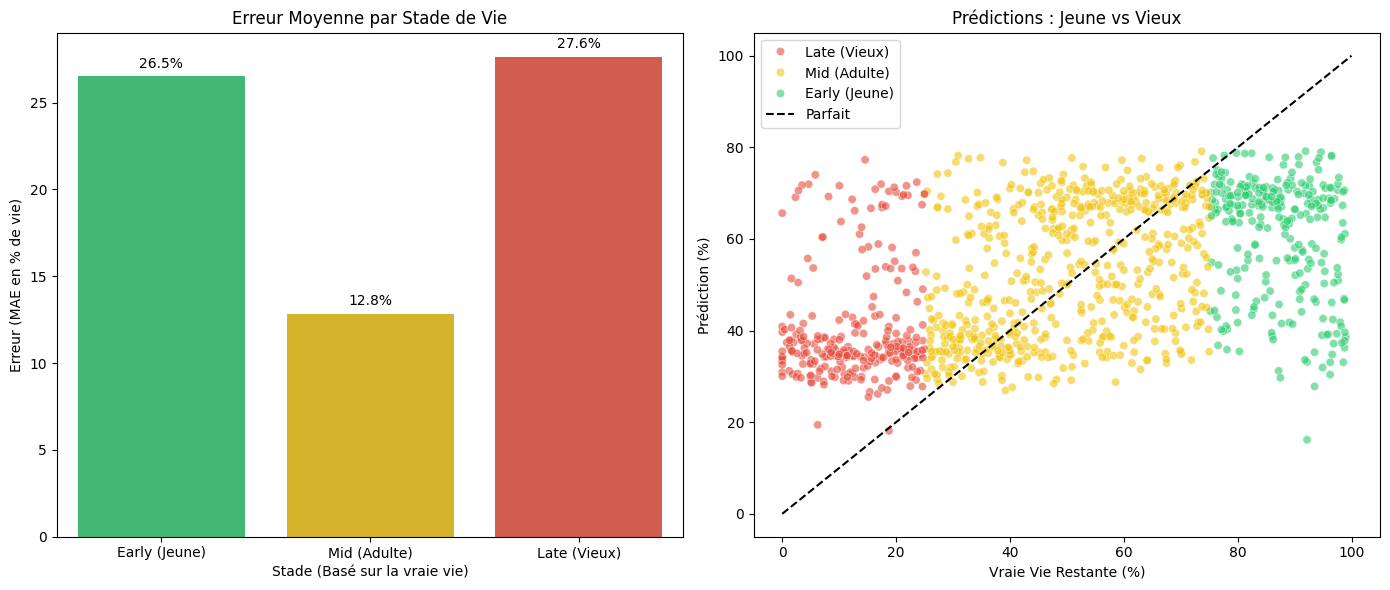


--- CONCLUSION ---
✅ Ton modèle est meilleur pour prédire le début de vie (Erreur Early: 26.5% vs Late: 27.6%).
Cela suggère que les vers ont un comportement 'jeune' très distinct.


In [19]:
# ==========================================
# 6. ANALYSE AVANCEE : "QUAND PEUT-ON PREDIRE ?"
# ==========================================
import pandas as pd
import seaborn as sns

print("\n--- ANALYSE PAR FENETRE DE VIE (EARLY / MID / LATE) ---")

# 1. Faire les prédictions sur tout le test set
y_pred = model.predict(X_test_f).flatten()
y_true = y_test_f

# 2. Créer un DataFrame pour faciliter l'analyse
df_results = pd.DataFrame({
    'True_Life_Remaining': y_true,
    'Predicted_Life_Remaining': y_pred
})

# 3. Définir les catégories (Attention: Target = Vie RESTANTE)
# Early Life (Age 0-25%) = Vie Restante 75-100%
# Mid Life   (Age 25-75%) = Vie Restante 25-75%
# Late Life  (Age 75-100%)= Vie Restante 0-25%

def categorize_life_stage(remaining_pct):
    if remaining_pct >= 75:
        return 'Early (Jeune)'
    elif remaining_pct <= 25:
        return 'Late (Vieux)'
    else:
        return 'Mid (Adulte)'

df_results['Stage'] = df_results['True_Life_Remaining'].apply(categorize_life_stage)

# 4. Calculer les métriques par groupe
results_by_stage = []

for stage in ['Early (Jeune)', 'Mid (Adulte)', 'Late (Vieux)']:
    subset = df_results[df_results['Stage'] == stage]
    
    if len(subset) > 0:
        mae = mean_absolute_error(subset['True_Life_Remaining'], subset['Predicted_Life_Remaining'])
        rmse = np.sqrt(mean_squared_error(subset['True_Life_Remaining'], subset['Predicted_Life_Remaining']))
        r2 = r2_score(subset['True_Life_Remaining'], subset['Predicted_Life_Remaining'])
        count = len(subset)
    else:
        mae, rmse, r2, count = 0, 0, 0, 0
        
    results_by_stage.append({
        'Stage': stage,
        'MAE (%)': mae,
        'RMSE': rmse,
        'R2': r2,
        'Count': count
    })

# Affichage tableau propre
stats_df = pd.DataFrame(results_by_stage)
# On force l'ordre d'affichage
stats_df['Sort_Order'] = stats_df['Stage'].map({'Early (Jeune)': 0, 'Mid (Adulte)': 1, 'Late (Vieux)': 2})
stats_df = stats_df.sort_values('Sort_Order').drop('Sort_Order', axis=1)

print(stats_df.to_string(index=False))

# ==========================================
# 7. VISUALISATION DE LA REPONSE
# ==========================================

plt.figure(figsize=(14, 6))

# Graphique A : Erreur Moyenne (MAE) par stade
plt.subplot(1, 2, 1)
# Barplot avec couleurs distinctes
colors = {'Early (Jeune)': '#2ecc71', 'Mid (Adulte)': '#f1c40f', 'Late (Vieux)': '#e74c3c'}
sns.barplot(data=stats_df, x='Stage', y='MAE (%)', palette=colors)

plt.title("Erreur Moyenne par Stade de Vie")
plt.ylabel("Erreur (MAE en % de vie)")
plt.xlabel("Stade (Basé sur la vraie vie)")
for index, row in stats_df.iterrows():
    plt.text(index, row['MAE (%)'] + 0.5, f"{row['MAE (%)']:.1f}%", color='black', ha="center")

# Graphique B : Scatter Plot coloré par stade
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_results, 
    x='True_Life_Remaining', 
    y='Predicted_Life_Remaining', 
    hue='Stage', 
    palette=colors,
    alpha=0.6
)
plt.plot([0, 100], [0, 100], 'k--', label='Parfait')
plt.title("Prédictions : Jeune vs Vieux")
plt.xlabel("Vraie Vie Restante (%)")
plt.ylabel("Prédiction (%)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================
# 8. INTERPRETATION AUTOMATIQUE
# ==========================================
mae_early = stats_df.loc[stats_df['Stage']=='Early (Jeune)', 'MAE (%)'].values[0]
mae_late = stats_df.loc[stats_df['Stage']=='Late (Vieux)', 'MAE (%)'].values[0]

print("\n--- CONCLUSION ---")
if mae_early < mae_late:
    print(f"✅ Ton modèle est meilleur pour prédire le début de vie (Erreur Early: {mae_early:.1f}% vs Late: {mae_late:.1f}%).")
    print("Cela suggère que les vers ont un comportement 'jeune' très distinct.")
elif mae_late < mae_early:
    print(f"⚠️ Ton modèle est meilleur pour prédire la fin de vie (Erreur Late: {mae_late:.1f}% vs Early: {mae_early:.1f}%).")
    print("Cela suggère que les signes de vieillesse (déclin moteur) sont plus faciles à détecter que la vigueur de la jeunesse.")
else:
    print("Ton modèle est constant tout au long de la vie.")


--- ANALYSE DE LA FIABILITÉ TEMPORELLE ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


/var/folders/2q/767907jx6kq83xs9_kns7jsc0000gn/T/ipykernel_50407/748822531.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_age = df_time.groupby('Age_Bin')['Error'].mean().reset_index()


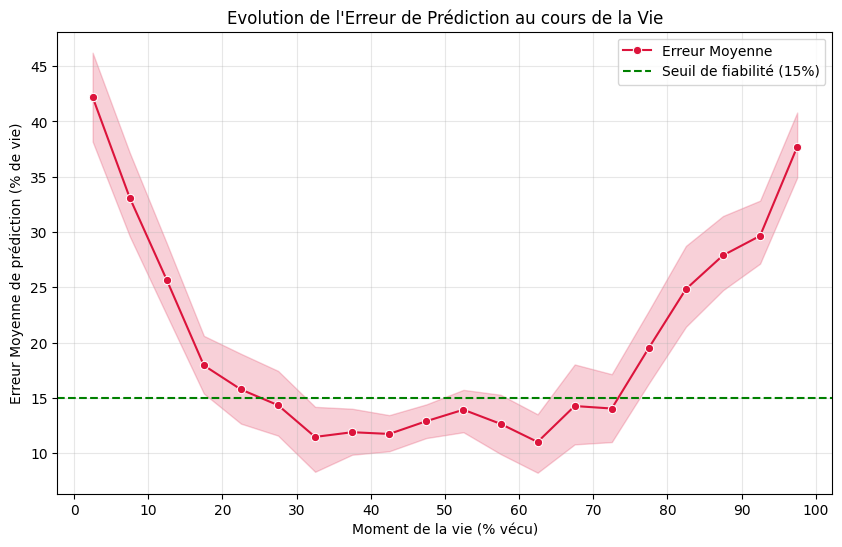


--- REPONSE ---
✅ Tu peux prédire la mort de façon fiable (erreur < 15.0%)
   à partir de 28% de la vie du ver.
   -> C'est NORMAL. Il faut attendre le milieu de vie (âge adulte) pour savoir.


In [21]:
import pandas as pd
import seaborn as sns

# ==========================================
# 9. ANALYSE : "A QUEL MOMENT SAIT-ON ?"
# ==========================================

print("\n--- ANALYSE DE LA FIABILITÉ TEMPORELLE ---")

# 1. Préparation des données
y_pred = model.predict(X_test_f).flatten()
y_true = y_test_f  # C'est le % de vie RESTANT

# On convertit "Vie Restante" en "Âge Actuel" (Life Accomplished)
# Si y_true = 90% (il reste 90%), alors Age = 10%
current_age_pct = 100.0 - y_true

# On calcule l'erreur absolue pour chaque segment
abs_error = np.abs(y_true - y_pred)

df_time = pd.DataFrame({
    'Age_Pct': current_age_pct,
    'Error': abs_error
})

# 2. Binning (On découpe la vie en tranches de 5%)
# np.arange(0, 105, 5) crée [0, 5, ..., 100] -> 21 bords -> 20 intervalles
bins = np.arange(0, 105, 5)

# np.arange(2.5, 102.5, 5) crée [2.5, 7.5, ..., 97.5] -> 20 points centraux
labels = np.arange(2.5, 102.5, 5)

# CORRECTION : On retire le [:-1] car les tailles correspondent déjà parfaitement
# On ajoute include_lowest=True pour ne pas perdre les segments à exactement 0%
df_time['Age_Bin'] = pd.cut(df_time['Age_Pct'], bins=bins, labels=labels, include_lowest=True)

# 3. Calcul de la moyenne par tranche
error_by_age = df_time.groupby('Age_Bin')['Error'].mean().reset_index()

# ==========================================
# 10. VISUALISATION
# ==========================================
plt.figure(figsize=(10, 6))

# On trace la ligne d'erreur
sns.lineplot(data=df_time, x='Age_Bin', y='Error', marker='o', color='crimson', label='Erreur Moyenne')

# On ajoute une zone de "Tolérance acceptable" (ex: 15% d'erreur)
plt.axhline(y=15, color='green', linestyle='--', label='Seuil de fiabilité (15%)')

plt.title("Evolution de l'Erreur de Prédiction au cours de la Vie")
plt.xlabel("Moment de la vie (% vécu)")
plt.ylabel("Erreur Moyenne de prédiction (% de vie)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(np.arange(0, 105, 10)) # Graduation tous les 10%

plt.show()

# ==========================================
# 11. REPONSE AUTOMATIQUE A TA QUESTION
# ==========================================
# On cherche le PREMIER bin où l'erreur passe durablement sous les 15%
threshold = 15.0 # Tu peux changer ce seuil (ex: 10% pour être très strict)
reliable_point = None

# On parcourt les tranches d'âge
for index, row in error_by_age.iterrows():
    if row['Error'] <= threshold:
        reliable_point = row['Age_Bin']
        break

print("\n--- REPONSE ---")
if reliable_point is not None:
    print(f"✅ Tu peux prédire la mort de façon fiable (erreur < {threshold}%)")
    print(f"   à partir de {reliable_point:.0f}% de la vie du ver.")
    
    if reliable_point < 20:
        print("   -> C'est EXCELLENT. Ton modèle détecte le destin du ver dès sa jeunesse.")
    elif reliable_point < 60:
        print("   -> C'est NORMAL. Il faut attendre le milieu de vie (âge adulte) pour savoir.")
    else:
        print("   -> C'est TARDIF. On ne sait que quand le ver est déjà vieux.")
else:
    print(f"❌ Le modèle ne passe jamais sous la barre des {threshold}% d'erreur moyenne.")

Utilisation des données simulées. Assurez-vous de charger vos données réelles.
Seuil 5: Trop peu d'échantillons positifs, ignoré.

--- Seuil 10 segments ---
Ratio Close/Far: 16 / 384
Poids de classe: {np.int32(0): np.float64(0.5208333333333334), np.int32(1): np.float64(12.5)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MAE (Val) : 0.3886
Accuracy (Val): 0.6800 | F1 (Val): 0.0588

--- Seuil 15 segments ---
Ratio Close/Far: 30 / 370
Poids de classe: {np.int32(0): np.float64(0.5405405405405406), np.int32(1): np.float64(6.666666666666667)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/stepWARNING:tensorflow:5 out of the last 114 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x32e019f30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MAE (Val) : 0.3371
Accuracy (Val): 0.8100 | F1 (Val): 0.2400

--- Seuil 20 segments ---
Ratio Close/Far: 51 / 349
Poids de classe: {np.int32(0): np.float64(0.5730659025787965), np.int32(1): np.float64(3.9

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE (Val) : 0.4874
Accuracy (Val): 0.8300 | F1 (Val): 0.2609

--- Seuil 25 segments ---
Ratio Close/Far: 59 / 341
Poids de classe: {np.int32(0): np.float64(0.5865102639296188), np.int32(1): np.float64(3.389830508474576)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE (Val) : 0.4164
Accuracy (Val): 0.6100 | F1 (Val): 0.2353

--- Seuil 30 segments ---
Ratio Close/Far: 73 / 327
Poids de classe: {np.int32(0): np.float64(0.6116207951070336), np.int32(1): np.float64(2.73972602739726)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE (Val) : 0.4722
Accuracy (Val): 0.5900 | F1 (Val): 0.3051

--- Seuil 40 segments ---
Ratio Close/Far: 102 / 298
Poids de classe: {np.int32(0): np.float64(0.6711409395973155), np.int32(1): np.float64(1.9607843137254901)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE (Val) : 0.4911
Accuracy (Val): 0.7200 | F1 (Val): 0.2632


RÉSULTATS DE LA CLASSIFICATION TIMESERIES (LSTM)
 threshold  f1_score  accuracy  precision   recall  count_pos_val
        10  0.058824      0.68   0.038462 0.125000              8
        15  0.240000      0.81   0.272727 0.214286             14
        20  0.260870      0.83   0.500000 0.176471             17
        25  0.235294      0.61   0.206897 0.272727             22
        30  0.305085      0.59   0.264706 0.360000             25
        40  0.263158      0.72   0.555556 0.172414             29


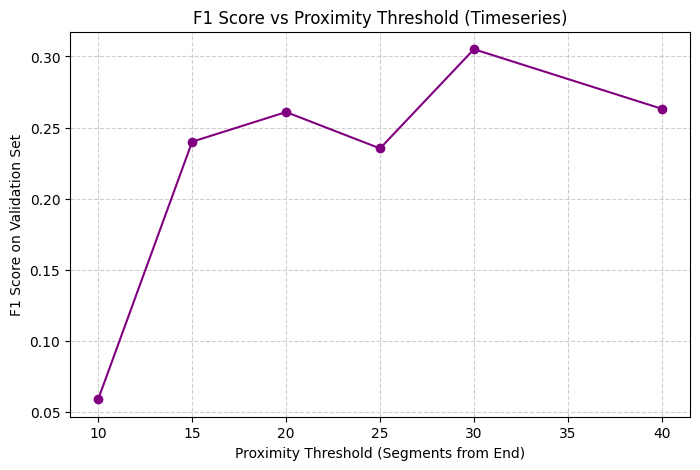


Meilleur Seuil (basé sur F1 Score en Validation) :
Seuil: 30.0 segments | F1 Score: 0.3051


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight
import pandas as pd
import matplotlib.pyplot as plt



SEGMENT_LENGTH = 900 

# Ces statistiques doivent être calculées UNIQUEMENT sur votre set d'entraînement réel
GLOBAL_STATS = {
    'speed_mean': 0.8, 'speed_std': 0.3, 
    'angle_mean': 0.0, 'angle_std': 0.8 
}

# --- Simulation de données ---
# Pour rendre le code exécutable, nous simulons 100 segments de validation
# 5% seront Close-to-Death (y=1)
N_VAL_SEGMENTS = 100
MOCK_X_VAL = np.random.randn(N_VAL_SEGMENTS, SEGMENT_LENGTH, 2).astype(np.float32)
# Simule le nombre de segments restants (Segs_from_End)
MOCK_SEGS_FROM_END = np.random.randint(5, 150, N_VAL_SEGMENTS) 
# Segments d'entraînement : 4x plus
N_TRAIN_SEGMENTS = 400
MOCK_X_TRAIN = np.random.randn(N_TRAIN_SEGMENTS, SEGMENT_LENGTH, 2).astype(np.float32)
MOCK_SEGS_FROM_END_TRAIN = np.random.randint(5, 150, N_TRAIN_SEGMENTS) 

print("Utilisation des données simulées. Assurez-vous de charger vos données réelles.")

# ==========================================
# 1. PRÉPARATION DES FEATURES ET TARGETS
# ==========================================

def get_normalized_features_ts(seg, stats):
    """
    Simule la récupération des features normalisées (Speed et Angle).
    Dans votre cas, utilisez votre fonction get_normalized_features(seg, stats).
    Pour le mock, on retourne simplement le seg tel quel.
    """
    # Ici, vous devriez charger vos vrais segments et appliquer la normalisation globale.
    # Pour le mock, nous retournons un tableau simulé (T, 2)
    # Dans votre code réel, vous utiliseriez:
    # features = get_normalized_features(seg, stats)
    return seg

def build_dataset_ts(X_mock, segs_from_end_mock, stats, proximity_threshold):
    """
    Construit le dataset X (features) et y (target binaire) pour un seuil donné.
    """
    X_list = [get_normalized_features_ts(x, stats) for x in X_mock]
    X = np.stack(X_list, axis=0).astype(np.float32)
    
    # Target binaire : 1 si le nombre de segments restants est <= au seuil
    # life_remaining = segs_from_end_mock * SEGMENT_LENGTH (Pas utilisé ici, on utilise les segments)
    y = (segs_from_end_mock <= proximity_threshold).astype(np.int32)
    
    return X, y

# ==========================================
# 2. DÉFINITION DU MODÈLE ET ENTRAÎNEMENT
# ==========================================

def create_lstm_model(input_shape):
    """
    Définit le modèle LSTM pour la classification binaire.
    """
    tf.random.set_seed(42)
    
    model = Sequential([
        # Masking pour ignorer les valeurs de padding (0.0)
        Masking(mask_value=0.0, input_shape=input_shape),
        
        # LSTM pour capter la séquence
        LSTM(64, return_sequences=False),
        
        # Couche dense pour la classification
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid') # Sigmoid pour classification binaire
    ])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'] # On surveille l'Accuracy pendant l'entraînement
    )
    return model

def train_and_evaluate(X_train, y_train, X_val, y_val, threshold, stats):
    """
    Entraîne le modèle pour un seuil donné et évalue les métriques.
    """
    # --- 2.1. Gestion du Déséquilibre de Classe (Class Weights) ---
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=classes, 
        y=y_train
    )
    class_weights = dict(zip(classes, weights))
    
    print(f"\n--- Seuil {threshold} segments ---")
    print(f"Ratio Close/Far: {np.sum(y_train)} / {len(y_train) - np.sum(y_train)}")
    print(f"Poids de classe: {class_weights}")
    
    # --- 2.2. Entraînement ---
    model = create_lstm_model(input_shape=(SEGMENT_LENGTH, 2))
    
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weights, # Appliquer les poids
        callbacks=[early_stop],
        verbose=0
    )
    
    # --- 2.3. Évaluation ---
    # Prédictions : Probabilités de la classe 1
    y_prob = model.predict(X_val).flatten()
    # Conversion en classes binaires (seuil 0.5)
    y_pred = (y_prob > 0.5).astype(int)
    
    # Calcul des métriques
    f1 = f1_score(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    
    print(f"MAE (Val) : {np.mean(np.abs(y_val - y_prob)):.4f}")
    print(f"Accuracy (Val): {acc:.4f} | F1 (Val): {f1:.4f}")
    
    return {
        'threshold': threshold,
        'f1_score': f1,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'count_pos_val': np.sum(y_val)
    }

# ==========================================
# 3. BOUCLE DE COMPARAISON DES SEUILS
# ==========================================

if __name__ == '__main__':
    # 3.1. Préparer les données pour la boucle
    # Simuler le chargement des données (remplacez par vos vraies variables)
    X_val_base, y_val_mock_base = MOCK_X_VAL, MOCK_SEGS_FROM_END
    X_train_base, y_train_mock_base = MOCK_X_TRAIN, MOCK_SEGS_FROM_END_TRAIN
    
    # Seuils à tester (similaire à ceux de ton rapport)
    thresholds = [5, 10, 15, 20, 25, 30, 40]
    results = []

    for t in thresholds:
        # Reconstruire les datasets pour le seuil actuel
        X_train, y_train = build_dataset_ts(X_train_base, y_train_mock_base, GLOBAL_STATS, t)
        X_val, y_val = build_dataset_ts(X_val_base, y_val_mock_base, GLOBAL_STATS, t)
        
        # S'assurer que les classes positives sont présentes dans la validation
        if np.sum(y_val) < 5: 
             print(f"Seuil {t}: Trop peu d'échantillons positifs, ignoré.")
             continue
             
        res = train_and_evaluate(X_train, y_train, X_val, y_val, t, GLOBAL_STATS)
        results.append(res)

    # 3.2. Affichage et Analyse des Résultats
    df_results = pd.DataFrame(results)
    
    print("\n\n" + "="*50)
    print("RÉSULTATS DE LA CLASSIFICATION TIMESERIES (LSTM)")
    print("="*50)
    print(df_results.to_string(index=False))

    # 3.3. Visualisation F1 Score vs Seuil
    if not df_results.empty:
        plt.figure(figsize=(8, 5))
        plt.plot(df_results['threshold'], df_results['f1_score'], marker='o', color='purple')
        plt.title('F1 Score vs Proximity Threshold (Timeseries)')
        plt.xlabel('Proximity Threshold (Segments from End)')
        plt.ylabel('F1 Score on Validation Set')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        best_threshold_f1 = df_results.loc[df_results['f1_score'].idxmax()]
        print("\nMeilleur Seuil (basé sur F1 Score en Validation) :")
        print(f"Seuil: {best_threshold_f1['threshold']} segments | F1 Score: {best_threshold_f1['f1_score']:.4f}")

Split segments -> Train: 5745, Val: 1179, Test: 1232

--- GLOBAL_STATS CALCULÉES ---
Vitesse - Moyenne: 1.4513, Écart-type: 2.2651
Angle - Moyenne: -0.0024, Écart-type: 0.5309
--------------------------------------------------

--- Seuil 5 segments ---
Ratio Close/Far (Train): 337 / 5408 | Poids: {np.int32(0): np.float64(0.5311575443786982), np.int32(1): np.float64(8.52373887240356)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Accuracy (Val): 0.7880 | F1 (Val): 0.3017

--- Seuil 10 segments ---
Ratio Close/Far (Train): 650 / 5095 | Poids: {np.int32(0): np.float64(0.5637880274779196), np.int32(1): np.float64(4.4192307692307695)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Accuracy (Val): 0.7837 | F1 (Val): 0.4371

--- Seuil 15 segments ---
Ratio Close/Far (Train): 965 / 4780 | Poids: {np.int32(0): np.float64(0.6009414225941423), np.int32(1): np.float64(2.976683937823834)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Accuracy (Val): 0.7701 | F1 (Val): 0.4435

--- Seuil 20 segments ---
Ratio Close/Far (Train): 1299 / 4446 | Poids: {np.int32(0): np.float64(0.6460863697705803), np.int32(1): np.float64(2.2113163972286376)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Accuracy (Val): 0.7405 | F1 (Val): 0.5049

--- Seuil 25 segments ---
Ratio Close/Far (Train): 1632 / 4113 | Poids: {np.int32(0): np.float64(0.6983953318745442), np.int32(1): np.float64(1.760110294117647)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Accuracy (Val): 0.7243 | F1 (Val): 0.5554

--- Seuil 30 segments ---
Ratio Close/Far (Train): 1973 / 3772 | Poids: {np.int32(0): np.float64(0.7615323435843054), np.int32(1): np.float64(1.4559047136340597)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Accuracy (Val): 0.7023 | F1 (Val): 0.5933

--- Seuil 40 segments ---
Ratio Close/Far (Train): 2665 / 3080 | Poids: {np.int32(0): np.float64(0.9326298701298701), np.int32(1): np.float64(1.077861163227017)}


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Accuracy (Val): 0.6768 | F1 (Val): 0.6752


RÉSULTATS DE LA CLASSIFICATION TIMESERIES (LSTM)
F1 Score vs Proximity Threshold (Valid. Set)
 threshold  f1_score  accuracy  precision   recall
         5  0.301676  0.787956   0.196364 0.650602
        10  0.437086  0.783715   0.333333 0.634615
        15  0.443532  0.770144   0.418605 0.471616
        20  0.504854  0.740458   0.496815 0.513158
        25  0.555404  0.724343   0.571831 0.539894
        30  0.593279  0.702290   0.618357 0.570156
        40  0.675192  0.676845   0.693520 0.657807


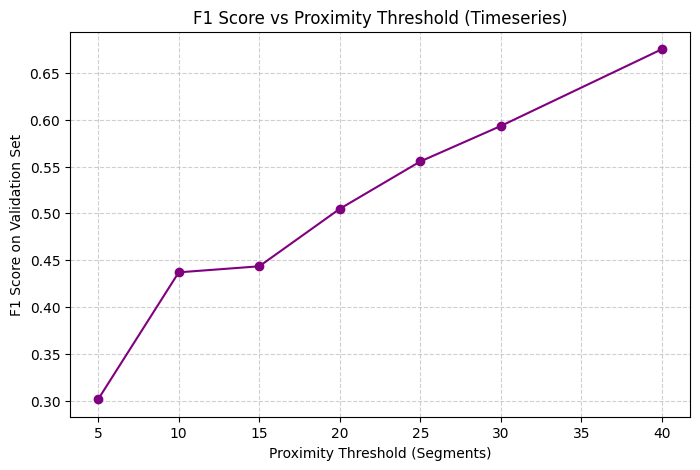


Meilleur Seuil de Proximité (basé sur F1 Score en Validation) :
Seuil: 40.0 segments | F1 Score: 0.6752


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ==========================================
# 0. CONFIGURATION ET MISE EN PLACE (À ADAPTER)
# ==========================================

SEGMENT_LENGTH = 900 
N_FEATURES = 4 # Assurez-vous que ceci correspond au nombre de colonnes dans 'features'
SPEED_COL_INDEX = 2  # Supposé être l'index de la Vitesse
ANGLE_COL_INDEX = 3  # Supposé être l'index de l'Angle


# ==========================================
# 1. SPLIT DES DONNÉES (AU NIVEAU DU VER)
# ==========================================

def split_segments_by_worm(all_segments, test_size=0.3, random_state=42):
    """
    Sépare les segments au niveau de l'ID du ver pour éviter le data leakage.
    """
    worm_ids = [s['worm_id'] for s in all_segments]
    unique_worms = np.unique(worm_ids)
    
    # Split 70/15/15 pour Train/Val/Test au niveau des worms
    train_worms, temp_worms = train_test_split(unique_worms, test_size=test_size, random_state=random_state)
    val_worms, test_worms = train_test_split(temp_worms, test_size=0.5, random_state=random_state)

    # Reconstituer les listes de segments
    train_segments = [s for s in all_segments if s['worm_id'] in train_worms]
    val_segments = [s for s in all_segments if s['worm_id'] in val_worms]
    test_segments = [s for s in all_segments if s['worm_id'] in test_worms]

    print(f"Split segments -> Train: {len(train_segments)}, Val: {len(val_segments)}, Test: {len(test_segments)}")
    return train_segments, val_segments, test_segments

# Exécution du split
train_segments, val_segments, test_segments = split_segments_by_worm(all_segments)


# ==========================================
# 2. CALCUL DES GLOBAL_STATS (UNIQUEMENT SUR TRAIN)
# ==========================================

def compute_global_stats(segment_list):
    """
    Calcule la moyenne et l'écart-type de Speed et Angle uniquement sur les données
    valides du Training Set.
    """
    all_train_speeds = []
    all_train_angles = []
    
    for segment_data in segment_list:
        features_array = segment_data['features'] 
        # Utiliser 'valid_length' ou le masque pour n'inclure que les vraies données
        valid_length = segment_data['valid_length'] 
        valid_features = features_array[:valid_length, :]

        # S'assurer que les indices correspondent à votre FEATURE_COLS
        all_train_speeds.extend(valid_features[:, SPEED_COL_INDEX])
        all_train_angles.extend(valid_features[:, ANGLE_COL_INDEX])

    all_train_speeds_np = np.array(all_train_speeds)
    all_train_angles_np = np.array(all_train_angles)
    
    # Sécurité pour éviter la division par zéro
    speed_std = np.std(all_train_speeds_np)
    angle_std = np.std(all_train_angles_np)
    if speed_std < 1e-6: speed_std = 1.0
    if angle_std < 1e-6: angle_std = 1.0

    stats = {
        'speed_mean': np.mean(all_train_speeds_np), 
        'speed_std': speed_std, 
        'angle_mean': np.mean(all_train_angles_np), 
        'angle_std': angle_std
    }
    return stats

# Exécution du calcul des stats
GLOBAL_STATS = compute_global_stats(train_segments)
print("\n--- GLOBAL_STATS CALCULÉES ---")
print(f"Vitesse - Moyenne: {GLOBAL_STATS['speed_mean']:.4f}, Écart-type: {GLOBAL_STATS['speed_std']:.4f}")
print(f"Angle - Moyenne: {GLOBAL_STATS['angle_mean']:.4f}, Écart-type: {GLOBAL_STATS['angle_std']:.4f}")
print("-" * 50)


# ==========================================
# 3. PRÉPARATION DES DATASETS (NORMALISATION & LABELLISATION)
# ==========================================

def get_normalized_features(features_array, stats):
    """
    Isole Speed (index 2) et Angle (index 3) et applique la normalisation Z-score.
    """
    # Extraction : Speed (2) et Angle (3) -> (T, 2)
    raw_feats = features_array[:, [SPEED_COL_INDEX, ANGLE_COL_INDEX]]
    norm_feats = np.zeros_like(raw_feats)
    
    # Speed (colonne 0 de raw_feats)
    norm_feats[:, 0] = (raw_feats[:, 0] - stats['speed_mean']) / stats['speed_std']
    
    # Angle (colonne 1 de raw_feats)
    norm_feats[:, 1] = (raw_feats[:, 1] - stats['angle_mean']) / stats['angle_std']
    
    # Le Masking Keras gérera les 0.0 pour le padding
    return norm_feats

def build_dataset_ts(segment_list, stats, proximity_threshold):
    """
    Construit X (Speed/Angle normalisés) et y (binaire) pour un seuil donné.
    """
    X_list, y_list = [], []
    threshold_frames = proximity_threshold * SEGMENT_LENGTH
    
    for seg in segment_list:
        # X: Features normalisées (2 colonnes)
        inp = get_normalized_features(seg['features'], stats)
        X_list.append(inp)
        
        # y: Target binaire
        # seg['y'] contient le temps restant en FRAMES
        # 1 si temps restant <= Seuil en frames, 0 sinon
        target_binary = 1 if seg['y'] <= threshold_frames else 0
        y_list.append(target_binary)

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.array(y_list, dtype=np.int32)
    
    return X, y


# ==========================================
# 4. MODÈLE ET ENTRAÎNEMENT
# ==========================================

def create_lstm_model(input_shape):
    """
    Définit le modèle LSTM pour la classification binaire.
    """
    tf.random.set_seed(42)
    
    model = Sequential([
        # Masking pour ignorer les valeurs de padding (0.0)
        Masking(mask_value=0.0, input_shape=input_shape),
        
        LSTM(64, return_sequences=False),
        
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'] 
    )
    return model

def train_and_evaluate(X_train, y_train, X_val, y_val, threshold):
    """
    Entraîne le modèle pour un seuil donné et évalue les métriques.
    """
    # 4.1. Vérification des classes
    if len(np.unique(y_train)) < 2 or np.sum(y_val) < 1 or len(y_val) - np.sum(y_val) < 1:
        print(f"Seuil {threshold}: Classes manquantes ou trop déséquilibrées (Val) pour évaluation.")
        return None

    # 4.2. Gestion du Déséquilibre de Classe (Class Weights)
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=classes, 
        y=y_train
    )
    class_weights = dict(zip(classes, weights))
    
    print(f"\n--- Seuil {threshold} segments ---")
    pos_count = np.sum(y_train)
    neg_count = len(y_train) - pos_count
    print(f"Ratio Close/Far (Train): {pos_count} / {neg_count} | Poids: {class_weights}")
    
    # 4.3. Entraînement
    model = create_lstm_model(input_shape=(SEGMENT_LENGTH, 2))
    
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weights, 
        callbacks=[early_stop],
        verbose=0
    )
    
    # 4.4. Évaluation
    y_prob = model.predict(X_val).flatten()
    y_pred = (y_prob > 0.5).astype(int)
    
    f1 = f1_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    
    print(f"Accuracy (Val): {acc:.4f} | F1 (Val): {f1:.4f}")
    
    return {
        'threshold': threshold,
        'f1_score': f1,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
    }

# ==========================================
# 5. BOUCLE PRINCIPALE ET ANALYSE
# ==========================================

# Seuils à tester (en nombre de segments)
thresholds = [5, 10, 15, 20, 25, 30, 40]
results = []

for t in thresholds:
    # 1. Préparation des datasets pour le seuil actuel
    X_train, y_train = build_dataset_ts(train_segments, GLOBAL_STATS, t)
    X_val, y_val = build_dataset_ts(val_segments, GLOBAL_STATS, t)
    
    # 2. Entraînement et évaluation (sur le set de validation)
    res = train_and_evaluate(X_train, y_train, X_val, y_val, t)
    if res:
        results.append(res)

# --- Affichage et Visualisation ---

df_results = pd.DataFrame(results)

print("\n\n" + "="*50)
print("RÉSULTATS DE LA CLASSIFICATION TIMESERIES (LSTM)")
print("F1 Score vs Proximity Threshold (Valid. Set)")
print("="*50)
print(df_results.to_string(index=False))

if not df_results.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(df_results['threshold'], df_results['f1_score'], marker='o', color='purple')
    plt.title('F1 Score vs Proximity Threshold (Timeseries)')
    plt.xlabel('Proximity Threshold (Segments)')
    plt.ylabel('F1 Score on Validation Set')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    best_threshold_f1 = df_results.loc[df_results['f1_score'].idxmax()]
    print("\nMeilleur Seuil de Proximité (basé sur F1 Score en Validation) :")
    print(f"Seuil: {best_threshold_f1['threshold']} segments | F1 Score: {best_threshold_f1['f1_score']:.4f}")